In [1]:
"""Train HR-PPO agent."""
import logging
from contextlib import nullcontext
from datetime import datetime

import numpy as np
import torch
from box import Box
from stable_baselines3.common.policies import ActorCriticPolicy

import wandb

from typing import Callable

# Import networks
from networks.mlp_late_fusion import LateFusionMLP, LateFusionMLPPolicy
# Permutation equivariant network
from networks.perm_eq_late_fusion import LateFusionNet, LateFusionPolicy 

# Multi-agent as vectorized environment
from nocturne.envs.vec_env_ma import MultiAgentAsVecEnv
from utils.config import load_config_nb
from utils.random_utils import init_seed
from utils.render import make_video

# Custom callback
from utils.sb3.callbacks import CustomMultiAgentCallback

# Custom PPO class that supports multi-agent control
from utils.sb3.reg_ppo import RegularizedPPO
from utils.string_utils import datetime_to_str

logging.basicConfig(level=logging.INFO)

In [2]:

def linear_schedule(initial_value: float) -> Callable[[float], float]:
    """
    Linear learning rate schedule.

    :param initial_value: Initial learning rate.
    :return: schedule that computes
      current learning rate depending on remaining progress
    """
    def func(progress_remaining: float) -> float:
        """
        Progress will decrease from 1 (beginning) to 0.

        :param progress_remaining:
        :return: current learning rate
        """
        return progress_remaining * initial_value

    return func

def train(env_config, exp_config, video_config, model_config):  # pylint: disable=redefined-outer-name
    """Train RL agent using PPO."""
    # Ensure reproducability
    init_seed(env_config, exp_config, exp_config.seed)

    # Make environment
    from nocturne.envs.nocturne_gymnasium import NocturneGymnasium
    from stable_baselines3.common.vec_env import SubprocVecEnv
    from nocturne.envs.base_env import BaseEnv
    def make_env(env_config):
        return NocturneGymnasium(BaseEnv(config=env_config)) 

    env = SubprocVecEnv([lambda: make_env(env_config) for _ in range(4)])

    # Set up run
    datetime_ = datetime_to_str(dt=datetime.now())
    run_id = f"{datetime_}" if exp_config.track_wandb else None

    # Add scene to config
    # exp_config.scene = env.filename
    exp_config.track_wandb = False

    with wandb.init(
        project=exp_config.project,
        name=run_id,
        group=exp_config.group,
        config={**exp_config, **env_config},
        id=run_id,
        **exp_config.wandb,
    ) if exp_config.track_wandb else nullcontext() as run:
        # Set device
        exp_config.ppo.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # logging.info(f"Created env. Max # agents = {env_config.max_num_vehicles}.")
        # logging.info(f"Learning in {len(env.env.files)} scene(s): {env.env.files} | using {exp_config.ppo.device}")
        # logging.info(f"--- obs_space: {env.observation_space.shape[0]} ---")
        # logging.info(f"Action_space\n: {env.env.idx_to_actions}")
        
        # if exp_config.reg_weight > 0.0:
        #     logging.info(f"Regularization weight: {exp_config.reg_weight} with policy: {exp_config.human_policy_path}")

        # # Initialize custom callback
        custom_callback = CustomMultiAgentCallback(
            env_config=env_config,
            exp_config=exp_config,
            video_config=video_config,
            wandb_run=run if run_id is not None else None,
        )

        # Make scene init video to check expert actions
        # if exp_config.track_wandb:
        #     for model in exp_config.wandb_init_videos:
        #         make_video(
        #             env_config=env_config,
        #             exp_config=exp_config,
        #             video_config=video_config,
        #             filenames=[env.filename],
        #             model=model,
        #             n_steps=None,
        #         )
        exp_config.track_wandb = False
        
        human_policy = None
        # Load human reference policy if regularization is used
        if exp_config.reg_weight > 0.0:
            saved_variables = torch.load(exp_config.human_policy_path, map_location=exp_config.ppo.device)
            human_policy = ActorCriticPolicy(**saved_variables["data"])
            human_policy.load_state_dict(saved_variables["state_dict"])
            human_policy.to(exp_config.ppo.device)

        # Set up PPO
        model = RegularizedPPO(
            learning_rate=linear_schedule(1e-4),
            reg_policy=human_policy,
            reg_weight=exp_config.reg_weight,  # Regularization weight; lambda
            env=env,
            n_steps=exp_config.ppo.n_steps,
            policy=LateFusionPolicy,
            ent_coef=exp_config.ppo.ent_coef,
            vf_coef=exp_config.ppo.vf_coef,
            seed=exp_config.seed,  # Seed for the pseudo random generators
            verbose=exp_config.verbose,
            tensorboard_log=f"runs/{run_id}" if run_id is not None else None,
            device=exp_config.ppo.device,
            env_config=env_config,
            mlp_class=LateFusionNet,
            mlp_config=model_config,
        )

        # Log number of trainable parameters
        policy_params = filter(lambda p: p.requires_grad, model.policy.parameters())
        params = sum(np.prod(p.size()) for p in policy_params)
        exp_config.n_policy_params = params
        logging.info(f"Policy | trainable params: {params:,} \n")

        # Architecture
        logging.info(f"Policy | arch: \n {model.policy}")


        return env, model
        # Learn
        # model.learn(
        #     **exp_config.learn,
        #     callback=custom_callback,
        # )

In [3]:
env_config = load_config_nb("env_config")
exp_config = load_config_nb("exp_config")
video_config = load_config_nb("video_config")

env_config.num_files = 10

# Define model architecture
model_config = None
# model_config = Box(
#     {
#         "arch_ego_state": [8],
#         "arch_road_objects": [64],
#         "arch_road_graph": [128, 64],
#         "arch_shared_net": [128],
#         "act_func": "tanh",
#         "dropout": 0.0,
#         "last_layer_dim_pi": 64,
#         "last_layer_dim_vf": 64,
#     }
# )

# Train
env, model = train(
    env_config=env_config,
    exp_config=exp_config,
    video_config=video_config,
    model_config=model_config,
)


INFO:root:Policy | trainable params: 148,566 

INFO:root:Policy | arch: 
 LateFusionPolicy(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (pi_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (vf_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (mlp_extractor): LateFusionNet(
    (act_func): Tanh()
    (actor_ego_state_net): Sequential(
      (0): Linear(in_features=10, out_features=10, bias=True)
      (1): Dropout(p=0.0, inplace=False)
      (2): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
      (3): Tanh()
    )
    (actor_ro_net): Sequential(
      (0): Linear(in_features=13, out_features=64, bias=True)
      (1): Dropout(p=0.0, inplace=False)
      (2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (3): Tanh()
      (4): Linear(in_features=64, out_features=32, bias=True)
      (5): Dropout(p=0.0, inplace=False)
      (6): La

LateFusionNet(
  (act_func): Tanh()
  (actor_ego_state_net): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): Dropout(p=0.0, inplace=False)
    (2): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
    (3): Tanh()
  )
  (actor_ro_net): Sequential(
    (0): Linear(in_features=13, out_features=64, bias=True)
    (1): Dropout(p=0.0, inplace=False)
    (2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): Dropout(p=0.0, inplace=False)
    (6): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (7): Tanh()
  )
  (actor_rg_net): Sequential(
    (0): Linear(in_features=13, out_features=64, bias=True)
    (1): Dropout(p=0.0, inplace=False)
    (2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): Dropout(p=0.0, inplace=False)
    (6): LayerNorm((32,), eps=1e-05, elementwise_aff

In [5]:
env.reset()

array([{37: array([0.28523394, 0.49977985, 0.10757028, ..., 0.        , 0.        ,
              0.        ]), 0: array([0.2631481 , 0.50686294, 0.01567911, ..., 0.01      , 0.68215334,
              0.01584669]), 51: array([0.33037499, 0.583     , 0.02133806, ..., 0.        , 0.        ,
              0.        ]), 31: array([0.29642355, 0.51919246, 0.05890008, ..., 0.        , 0.        ,
              0.        ]), 34: array([0.29417717, 0.51871204, 0.11663519, ..., 0.        , 0.        ,
              0.        ]), 2: array([0.29118758, 0.50871187, 0.02653475, ..., 0.        , 0.        ,
              0.        ]), 1: array([0.28495339, 0.51357961, 0.02791023, ..., 0.        , 0.        ,
              0.        ]), 32: array([0.29227659, 0.5093497 , 0.11704891, ..., 0.        , 0.        ,
              0.        ]), 30: array([0.28525367, 0.50776368, 0.125852  , ..., 0.        , 0.        ,
              0.        ]), 33: array([0.3665545 , 0.60222054, 0.10613482, ..., 0.     

In [6]:
model.learn(1)

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In [4]:
y = env.observation_space.sample()

In [14]:
env.action_space

Discrete(25)

In [44]:
m = model.policy.eval()

In [50]:
m(torch.Tensor(y).unsqueeze(0).cuda())

(tensor([8], device='cuda:0'),
 tensor([[-0.5645]], device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([-3.6230], device='cuda:0', grad_fn=<SqueezeBackward1>))

In [42]:
from torchviz import make_dot

In [7]:
model.policy.mlp_extractor.cuda()(torch.Tensor(y).unsqueeze(0).cuda())

(tensor([[-0.6441, -1.3309,  0.5179, -0.4558,  0.6692,  0.3656,  1.1654,  1.2158,
           0.9431, -0.3549, -1.8127, -0.9146,  0.6600,  1.6707, -0.7357,  1.0185,
           1.4673,  0.1360,  1.5719, -0.4908, -0.5020, -0.1510, -2.7177, -0.9720,
          -1.5061,  0.1968,  0.1585,  0.3488, -0.5726,  0.5933, -0.0064, -1.4018,
           0.3319, -2.0170,  0.8157, -1.6580,  0.5165,  0.6804, -1.1788, -0.5321,
          -0.3591,  0.4718,  0.4771,  0.6652,  0.6524,  0.5661, -1.1508,  0.2073,
          -0.4792,  1.4354,  1.1228,  1.2609,  0.6219, -1.6648,  0.5761,  0.1294,
           0.4942, -1.1621,  1.7667, -1.1287,  0.1603,  0.8658,  0.2625, -0.8793]],
        device='cuda:0', grad_fn=<NativeLayerNormBackward0>),
 tensor([[-0.3148,  1.7813,  3.3665,  0.3266, -0.4068,  0.3553, -1.4078, -1.1260,
           0.0797,  0.4915,  0.1167, -0.4714, -0.7219,  1.0971, -0.2553, -0.5615,
           0.3163,  1.6734, -0.1957,  0.0232, -0.9513,  0.4992, -0.1210, -0.9332,
           0.1590, -1.3791,  0.474

In [8]:
# make_dot(model.policy(torch.Tensor(y).unsqueeze(0).cuda()), params=dict(model.policy.named_parameters()))

In [9]:
from torchview import draw_graph

In [10]:
torch.Tensor(y).unsqueeze(0).cpu()

tensor([[-0.2501,  0.3726,  0.1859,  ..., -0.5912,  0.7823, -1.0088]])

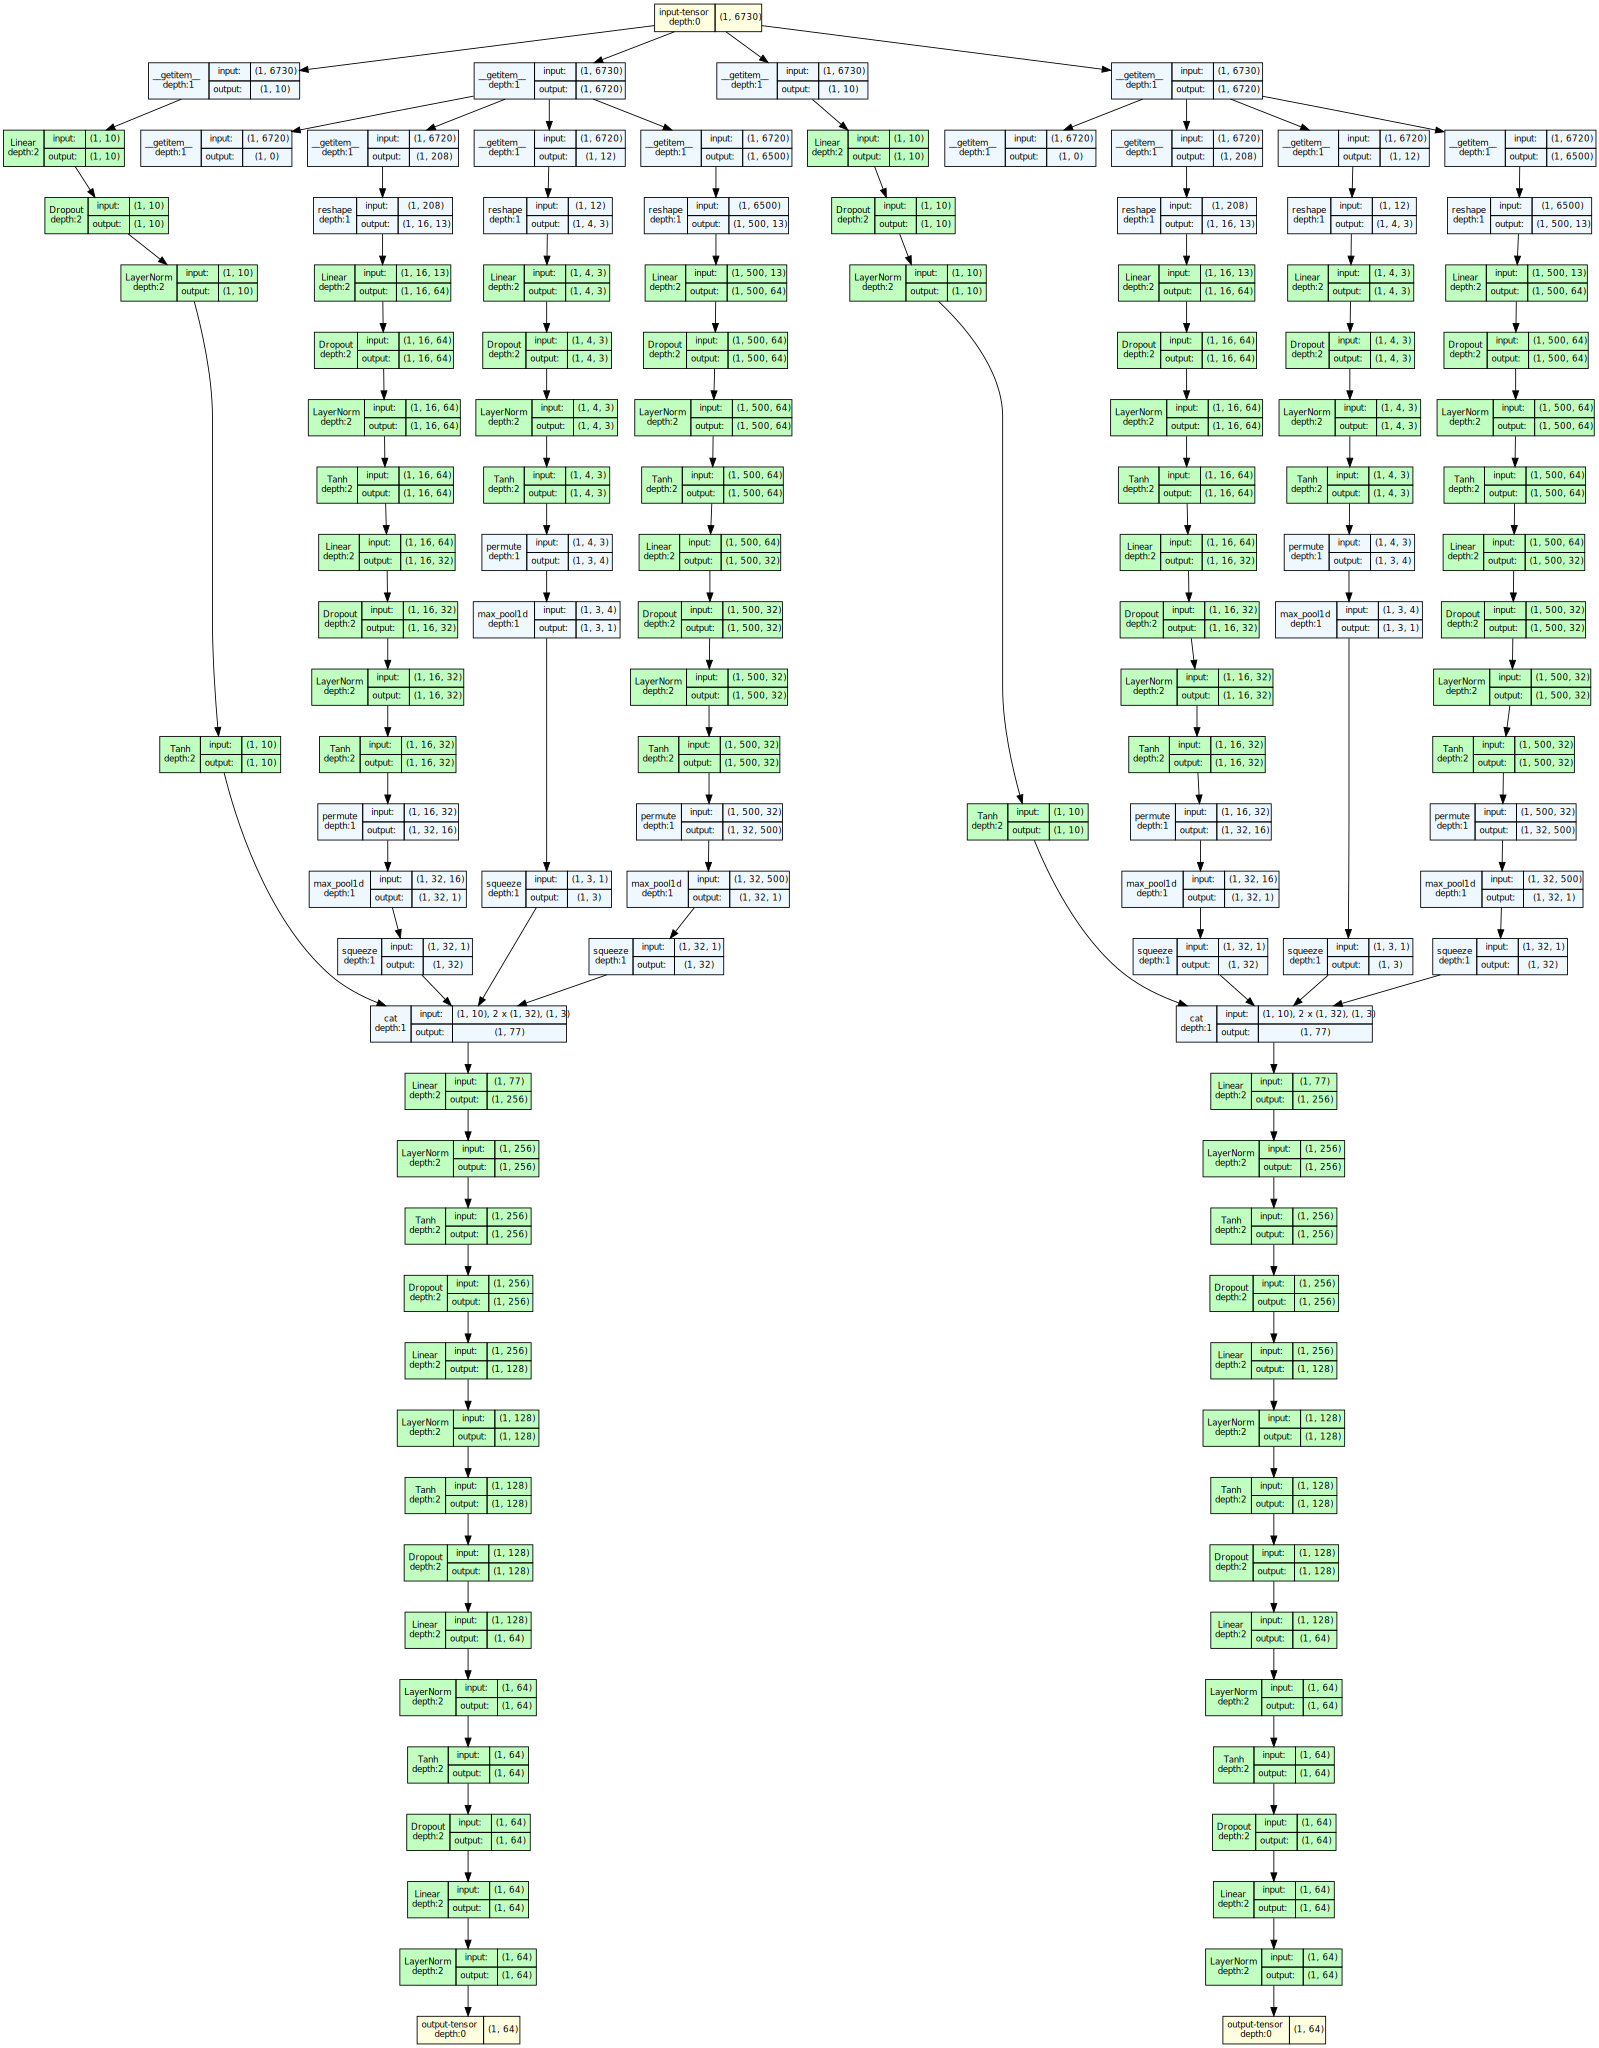

In [11]:
model_graph = draw_graph(model.policy.mlp_extractor, input_data=torch.Tensor(y).unsqueeze(0).cuda(), device='cuda')
model_graph.visual_graph

In [12]:
model_graph = draw_graph(model.policy, input_data=torch.Tensor(y).unsqueeze(0).cuda(), device='cuda')

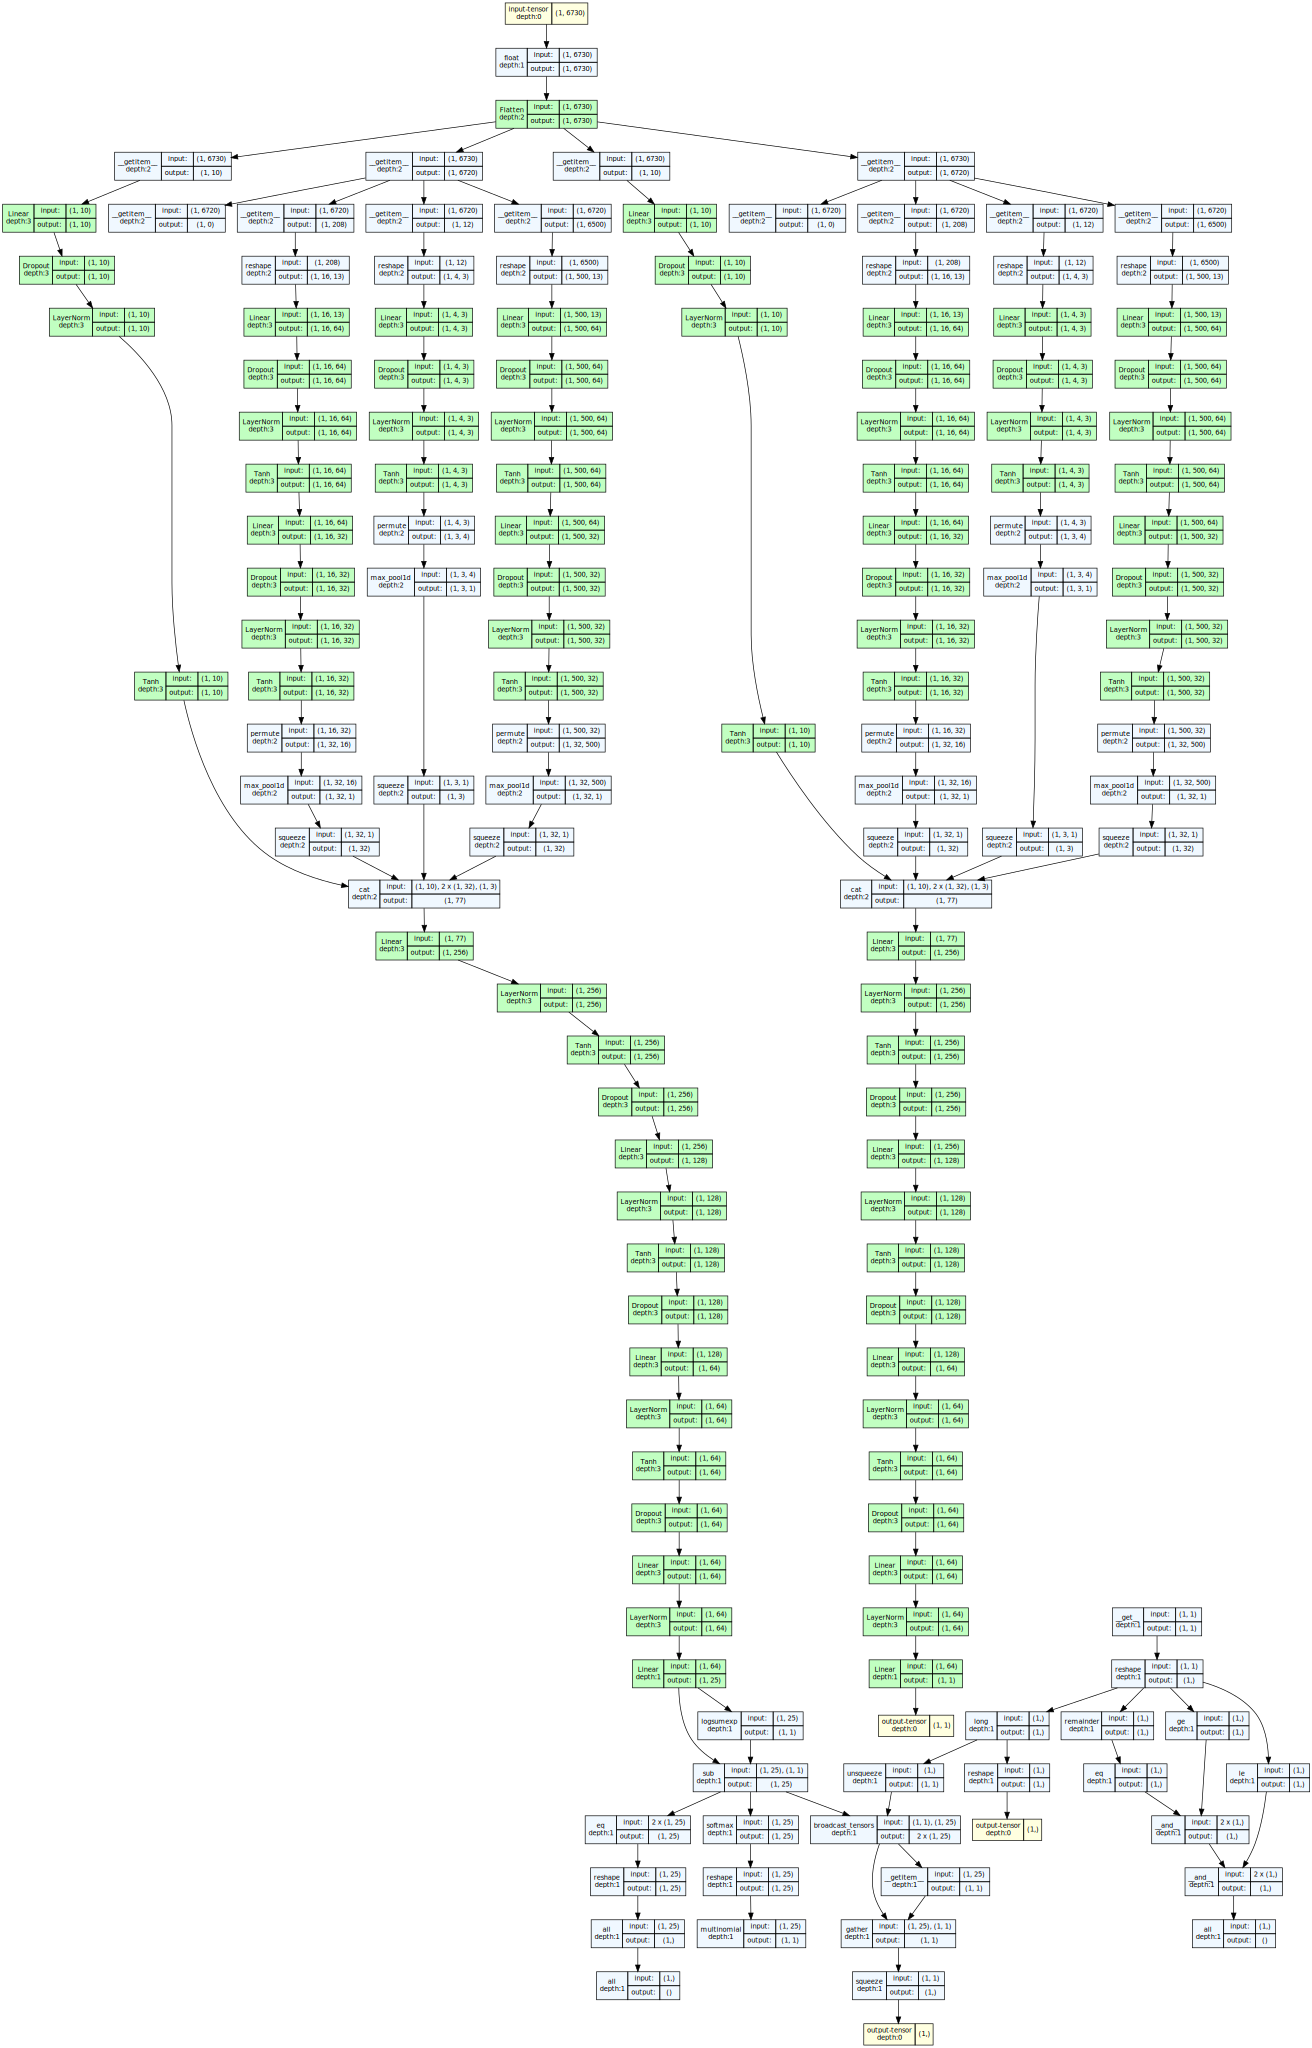

In [13]:
model_graph.visual_graph